# LICENSE PLATE DETECTION AND RECOGNITION 

##Importing Various Libraries

In [ ]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
import io
import requests
import json
from PIL import Image
from tqdm import tqdm

from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## The Dataset

### Reading the JSON file.

In [ ]:
df = pd.read_json("Indian_Number_plates.json", lines=True)
df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['number_plate'], 'notes': '', 'poi...",NaN


In [ ]:
# creating a new directory
!mkdir (Indian Number Plates)

/bin/bash: -c: line 0: syntax error near unexpected token `Indian'
/bin/bash: -c: line 0: `mkdir (Indian Number Plates)'


The images are then saved to the above created directory with their respective annotation information. The informatation that is recorded is  - imgae_width, image_height, x and y cordinates of top left corner and bottom right cornerof the bounding box. 

In [ ]:
dataset = dict()
dataset["image_name"] = list()
dataset["image_width"] = list()
dataset["image_height"] = list()
dataset["top_x"] = list()
dataset["top_y"] = list()
dataset["bottom_x"] = list()
dataset["bottom_y"] = list()

counter = 0
for index, row in tqdm(df.iterrows()):
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save("Indian Number Plates/licensed_car{}.jpeg".format(counter), "JPEG")
    
    dataset["image_name"].append("licensed_car{}".format(counter))
    
    data = row["annotation"]
    
    dataset["image_width"].append(data[0]["imageWidth"])
    dataset["image_height"].append(data[0]["imageHeight"])
    dataset["top_x"].append(data[0]["points"][0]["x"])
    dataset["top_y"].append(data[0]["points"][0]["y"])
    dataset["bottom_x"].append(data[0]["points"][1]["x"])
    dataset["bottom_y"].append(data[0]["points"][1]["y"])
    
    counter += 1
print("Downloaded {} car images.".format(counter))

237it [01:40,  2.36it/s]

Downloaded 237 car images.


In [ ]:
# creating a datafram object from the dictionary
df = pd.DataFrame(dataset)
df.head()

,image_name,image_width,image_height,top_x,top_y,bottom_x,bottom_y
0,licensed_car0,806,466,0.722084,0.587983,0.868486,0.688841
1,licensed_car1,494,449,0.161943,0.850780,0.582996,1.000000
2,licensed_car2,500,314,0.082000,0.697452,0.230000,0.828025
3,licensed_car3,500,469,0.434000,0.667377,0.718000,0.765458
4,licensed_car4,1001,563,0.208791,0.390764,0.865135,0.984014


In [ ]:
df.to_csv("indian_license_plates.csv", index=False)

###Preprocessing 
Since the image width and height has been fixed to 128px by 128px, those columns were deleted.

In [ ]:
df = pd.read_csv("indian_license_plates.csv")
df["image_name"] = df["image_name"] + ".jpeg"
df.drop(["image_width", "image_height"], axis=1, inplace=True)
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,licensed_car0.jpeg,0.722084,0.587983,0.868486,0.688841
1,licensed_car1.jpeg,0.161943,0.850780,0.582996,1.000000
2,licensed_car2.jpeg,0.082000,0.697452,0.230000,0.828025
3,licensed_car3.jpeg,0.434000,0.667377,0.718000,0.765458
4,licensed_car4.jpeg,0.208791,0.390764,0.865135,0.984014


Five random records are picked from the dataframe for a later visiual inspection of predictions. These records are then dropped from the original dataframe, to prevent the model to be trained on them.

In [ ]:
test_samples = np.random.randint(0, len(df), 5)
reduced_df = df.drop(test_samples, axis=0)

In [ ]:

WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def show_img(index):
    image = cv2.imread("Indian Number Plates/" + df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(df["top_x"].iloc[index] * WIDTH)
    ty = int(df["top_y"].iloc[index] * HEIGHT)
    bx = int(df["bottom_x"].iloc[index] * WIDTH)
    by = int(df["bottom_y"].iloc[index] * HEIGHT)

    #image = cv2.rectangle(image, (tx, ty), (bx, by), (0, 0, 255), 1)
    plt.imshow(image)
    plt.show()


Here, you can see a sample image from the dataset.

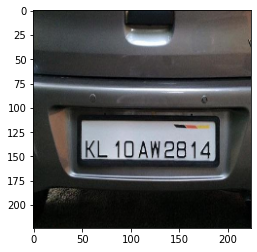

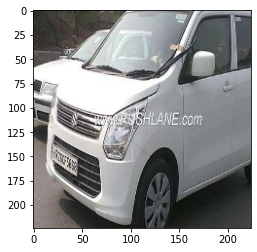

In [ ]:
show_img(144)
show_img(67)

## The Model

A fully connected Convolution network with 8 convolutinal layers, 4 max pool layers and 2 hidden layers.

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory="Indian Number Plates/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory="Indian Number Plates/",
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="validation")

Found 209 validated image filenames.
Found 23 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.6/logging/__init__.py", line 994, in emit
    msg = self.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 840, in format
    return fmt.format(record)
  File "/usr/lib/python3.6/logging/__init__.py", line 577, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.6/logging/__init__.py", line 338, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/usr/local/lib/python

In [ ]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(HEIGHT, WIDTH, CHANNEL)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,938,756
Trainable params: 3,224,068
Non-

In [ ]:
STEP_SIZE_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
STEP_SIZE_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step size:", STEP_SIZE_TRAIN)
print("Validation step size:", STEP_SIZE_VAL)

train_generator.reset()
validation_generator.reset()

Train step size: 7
Validation step size: 1


## Training

In [ ]:
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss="mse")

#The Adam optimiser is used here to find our losses.

In [ ]:
history = model.fit(train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=30)

Epoch 1/30
7/7 [==============================] - 100s 14s/step - loss: 0.0400 - val_loss: 0.0201
Epoch 2/30
7/7 [==============================] - 104s 15s/step - loss: 0.0127 - val_loss: 0.0182
Epoch 3/30
7/7 [==============================] - 97s 14s/step - loss: 0.0074 - val_loss: 0.0145
Epoch 4/30
7/7 [==============================] - 105s 15s/step - loss: 0.0043 - val_loss: 0.0141
Epoch 5/30
7/7 [==============================] - 98s 14s/step - loss: 0.0030 - val_loss: 0.0142
Epoch 6/30
7/7 [==============================] - 100s 14s/step - loss: 0.0023 - val_loss: 0.0125
Epoch 7/30
7/7 [==============================] - 97s 14s/step - loss: 0.0014 - val_loss: 0.0119
Epoch 8/30
7/7 [==============================] - 97s 14s/step - loss: 9.2254e-04 - val_loss: 0.0117
Epoch 9/30
7/7 [==============================] - 96s 14s/step - loss: 6.8880e-04 - val_loss: 0.0122
Epoch 10/30
7/7 [==============================] - 104s 15s/step - loss: 5.5587e-04 - val_loss: 0.0118
Epoch 11/30


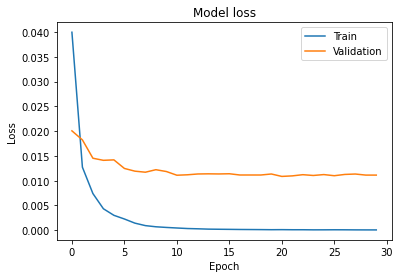

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

The model's success over the validation data is 80%. However, you can see that from the above figure, the training is stopped after 30th epoch. This may because of the low number of training samples or my model is not capable of learning such data. If you have an idea, please comment below.



## Testing


In [ ]:
model.evaluate(validation_generator, steps=STEP_SIZE_VAL)

#the evaluate() function will return the list of metrics that the model was compiled with.

1/1 [==============================] - 0s 1ms/step - loss: 0.0111


0.011124087497591972

In [ ]:
predictions = model.predict(validation_generator)
print(predictions)
# to find the probabilities, i.e the output of the last layer.

[[0.30315104 0.49895376 0.4959383  0.6569042 ]
 [0.1871297  0.42609516 0.77159107 0.75195646]
 [0.1902534  0.4543671  0.50300825 0.6884459 ]
 [0.3907156  0.46843022 0.71699256 0.6083109 ]
 [0.35868758 0.6591207  0.7340119  0.8242355 ]
 [0.44454017 0.5300252  0.6708746  0.68422866]
 [0.3338393  0.4514026  0.696354   0.62487185]
 [0.3812319  0.6556249  0.6145292  0.78660357]
 [0.22362486 0.5050229  0.65755373 0.7332235 ]
 [0.19841695 0.5339499  0.49050534 0.7651714 ]
 [0.37094206 0.43203992 0.72924316 0.60454804]
 [0.23531833 0.5672956  0.55389196 0.8058857 ]
 [0.3102421  0.37021208 0.66434276 0.6144131 ]
 [0.356147   0.49277213 0.64777803 0.70872784]
 [0.2508991  0.5575403  0.6788336  0.80639803]
 [0.20760238 0.31030753 0.89239264 0.8508255 ]
 [0.312451   0.5033847  0.59238577 0.64149666]
 [0.73394245 0.5745198  0.8702313  0.71253747]
 [0.31972682 0.45505726 0.6160627  0.6371938 ]
 [0.28386146 0.5043001  0.72024506 0.7447132 ]
 [0.21199444 0.6605406  0.57407004 0.8196002 ]
 [0.27407134 

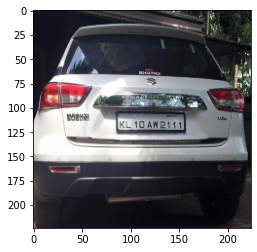

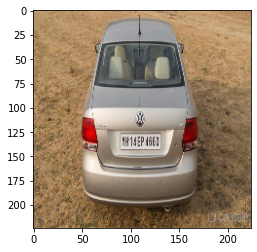

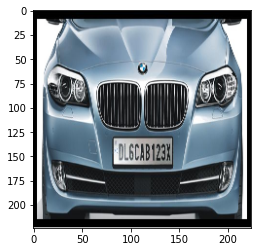

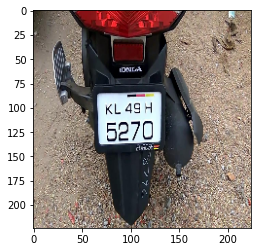

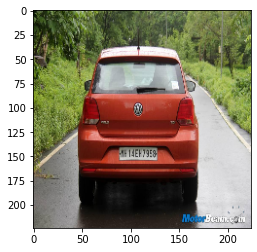

In [ ]:
for idx, row in df.iloc[test_samples].iterrows():    
    img = cv2.resize(cv2.imread("Indian Number Plates/" + row[0]) / 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    #image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 1)
    
    plt.imshow(img)
    plt.show()

#RECOGNITION

In [ ]:
WIDTH = 224
HEIGHT = 224
CHANNEL = 3

def show_number(index):
    image = cv2.imread("Indian Number Plates/" + df["image_name"].iloc[index])
    img = cv2.resize(image / 255.0, dsize=(WIDTH, HEIGHT))
    #image = cv2.cvtColor(image.astype(np.float32), cv2.COLOR_BGR2RGB)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #im_cr = img[int(yt):int(yb),int(xt):int(xb)]
  
    url_api = "https://api.ocr.space/parse/image"
    _, compressedimag = cv2.imencode(".jpeg", image, [1, 90])  # enccoding image
    file_byte = io.BytesIO(compressedimag) 
    result = requests.post(url_api,
                           files={"image.jpeg": file_byte},
                           data={"apikey": "c56514c74b88957"})

    result = (result.content.decode())  # decoding the result
    result = json.loads(result)
    final = result.get("ParsedResults")[0].get("ParsedText")  # traversing through the parsed text
    #final1 = result.get("ParsedResults")[0]
    # print(result)
    #print(final)
    #print(final1)
    plt.imshow(image)
    plt.show()
    if (final==""):
      print("UNABLE TO READ.")
    else:
       print(final)



Enter index: 144


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


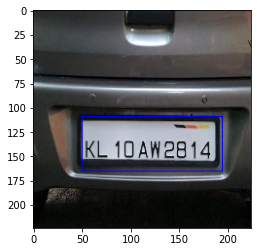

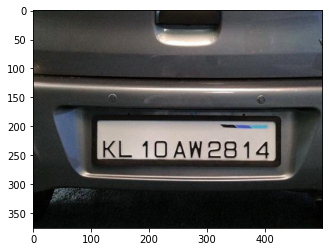

KL IOAW2814



In [ ]:
def plate_show():   
    index=int(input("Enter index: "))
    image=cv2.imread("Indian Number Plates/" + df["image_name"].iloc[index])
    img = cv2.resize(image/ 255.0, dsize=(WIDTH, HEIGHT))
    y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (0, 0, 255), 1)
    im_cr = image[int(yt):int(yb),int(xt):int(xb)]
    plt.imshow(image)
    plt.show()
    show_number(index)

plate_show()
    